In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

# import numpyro
# numpyro.set_host_device_count(8)

import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from corner import corner

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

In [2]:
def r2cz(r, H0):
    return r * H0

In [3]:
def make_mock(sigma_r, Rmax, H0, sigma_v, npoints, seed=42, ):
    gen = np.random.default_rng(seed)

    r_true = Rmax * gen.uniform(0, 1, npoints)**(1/3)
    r_obs = gen.normal(r_true, sigma_r, )

    cz_true = r2cz(r_true, H0=H0)
    cz_obs = gen.normal(cz_true, sigma_v, )

    return r_obs, cz_obs


Mock with 50 points created.


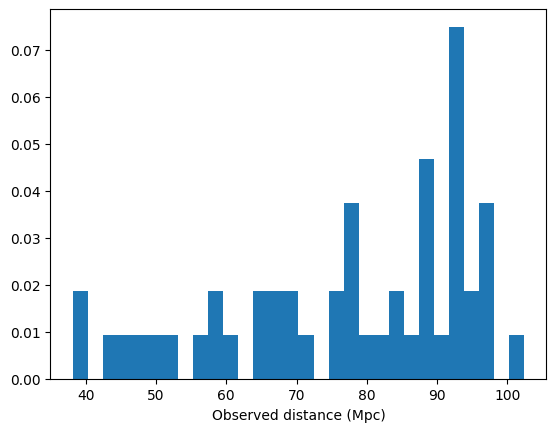

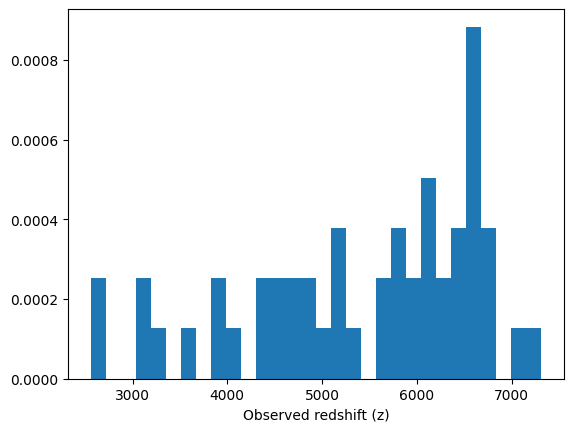

In [8]:
mock_kwargs = dict(sigma_r=5, Rmax=100, sigma_v=250, H0=70, npoints=50)


r_obs, cz_obs = make_mock(**mock_kwargs)

print(f"Mock with {r_obs.size} points created.")

plt.figure()
plt.hist(r_obs, bins=30, density=True, )
plt.xlabel("Observed distance (Mpc)")
plt.show()

plt.figure()
plt.hist(cz_obs, bins=30, density=True, )
plt.xlabel("Observed redshift (z)")
plt.show()


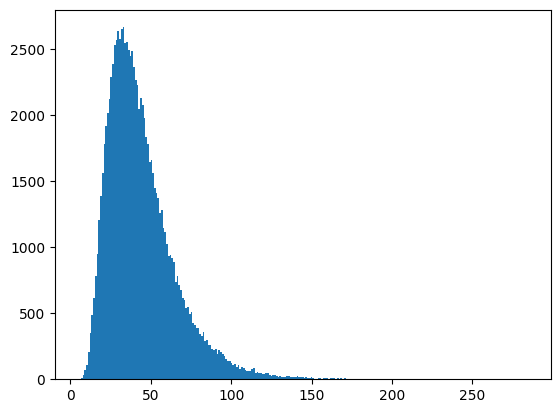

In [33]:
mu_mean = 33
mu_std = 1


mu = np.random.normal(mu_mean, mu_std, size=100000)
r = 10**(mu / 5 - 5)

plt.figure()
plt.hist(r, bins="auto")
plt.show()

In [23]:
def model(r_obs, cz_obs, sigma_r, Rmax, H0, sigma_v):
    H0 = sample("H0", Uniform(0.1, 200))
    with plate("points", r_obs.size):
        r_true = sample("r_true", Uniform(0, Rmax))
        # factor("lp_prior", 2 * jnp.log(r_true) - 3 * jnp.log(Rmax))
        sample("r_obs", Normal(r_true, sigma_r), obs=r_obs)

        cz_true = r2cz(r_true, H0=H0)
        sample("cz_obs", Normal(cz_true, sigma_v), obs=cz_obs)


In [24]:
num_warmup = 250
num_samples = 500
num_chains = 1
nrepeat = 100
progress_bar = nrepeat == 1

biases_dist = []
biases_H0 = []

for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    # Generate new mock data with a different seed each time
    r_obs, cz_obs = make_mock(**mock_kwargs, seed=42 + i)
    
    # Set up and run MCMC
    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples,
                num_chains=num_chains, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        r_obs=jnp.asarray(r_obs),
        cz_obs=jnp.asarray(cz_obs),
        sigma_r=mock_kwargs["sigma_r"],
        Rmax=mock_kwargs["Rmax"],
        H0=mock_kwargs["H0"],
        sigma_v=mock_kwargs["sigma_v"],
    )
    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()

    # Compute the bias for this run
    biases_dist.append((np.mean(samples["r_true"], axis=0) - r_obs) / np.std(samples["r_true"], axis=0))
    biases_H0.append((np.mean(samples["H0"], axis=0) - mock_kwargs["H0"]) / np.std(samples["H0"], axis=0))

# Stack into a 2D array: (nrepeat, n_galaxies)
biases_dist = np.stack(biases_dist, axis=0)
biases_H0 = np.stack(biases_H0, axis=0)


Running MCMC: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


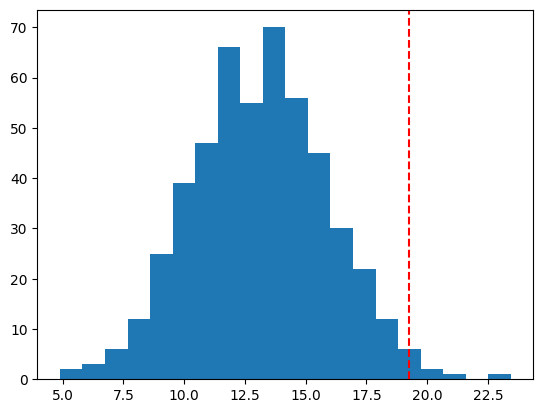

In [25]:
k = 30

plt.figure()
plt.hist(samples["r_true"][:, k], bins="auto")
plt.axvline(r_obs[k], color="red", linestyle="--", label="Observed")

plt.show()

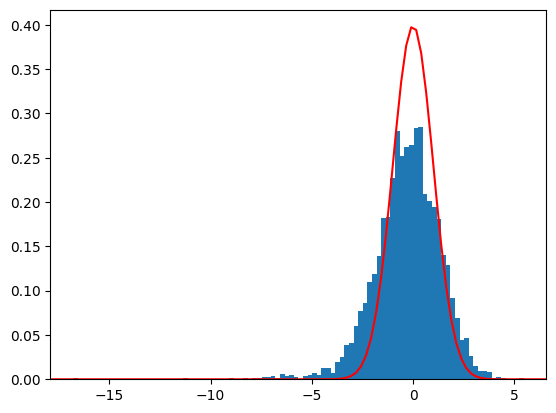

In [26]:
from scipy.stats import norm

plt.figure()
plt.hist(biases_dist.flatten(), bins="auto", density=1)

xlim = plt.xlim()
xrange = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xrange, norm.pdf(xrange, 0, 1), color="red", label="Standard Normal")

plt.xlim(*xlim)

# plt.xlim(-1, 1)

plt.show()


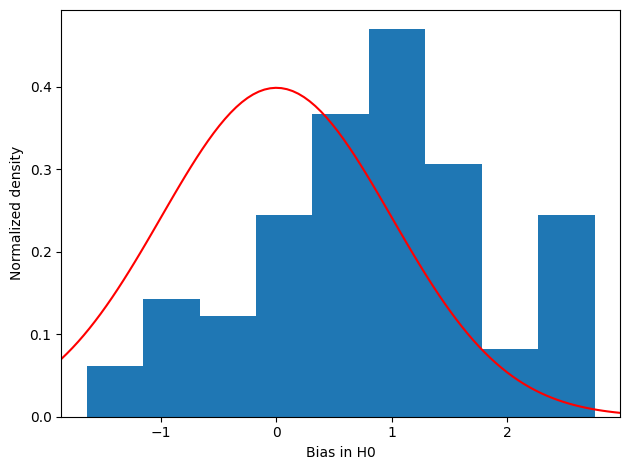

In [28]:
from scipy.stats import norm

plt.figure()
plt.hist(biases_H0.flatten(), bins="auto", density=1)

xlim = plt.xlim()
xrange = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xrange, norm.pdf(xrange, 0, 1), color="red", label="Standard Normal")

plt.xlim(*xlim)
plt.xlabel("Bias in H0")
plt.ylabel("Normalized density")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/biases_H0.png", dpi=450)

# plt.xlim(-1, 1)

plt.show()

In [12]:
keys = ["a_TFR", "b_TFR", "sigma_TFR"]

X = np.vstack([samples[key] for key in keys]).T
truths = np.array([mock_kwargs[key] for key in keys])



/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_45462/183250905.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


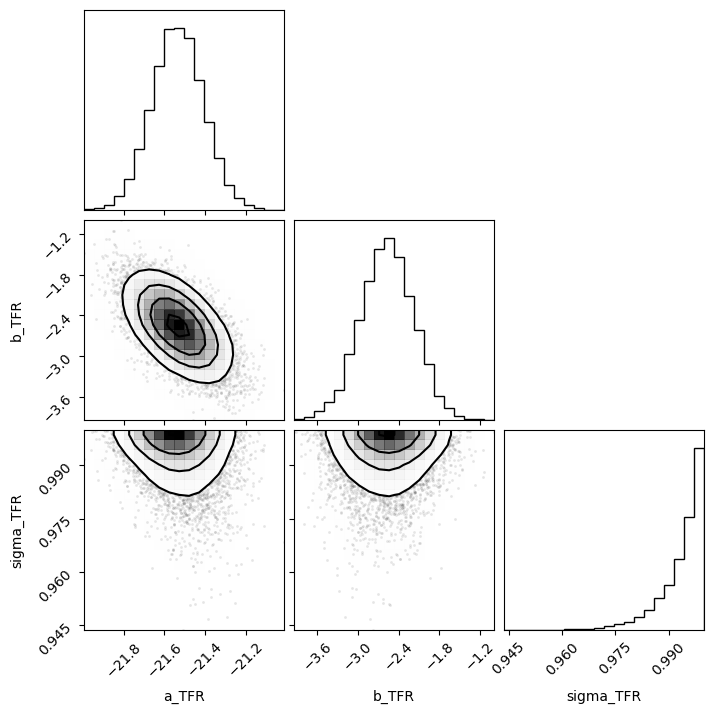

In [13]:
fig = corner(X, truths=truths, labels=keys,smooth=1)
fig.show()